In [30]:
!python --version

Python 3.10.12


In [31]:
import torch
torch.__version__

'2.5.1+cu121'

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from torchvision import models

In [34]:
train_dir="/kaggle/input/soil-image-classification/train_data"
test_dir="/kaggle/input/soil-image-classification/test"

In [35]:
#  Create Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),       # Gentle zoom crop
    transforms.RandomHorizontalFlip(p=0.5),                    # Natural horizontal variability
    transforms.RandomRotation(degrees=10),                     # Mild rotation only
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),# Slight translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])            # Standard normalization
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


In [37]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=train_transforms,
    test_transform=test_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names



(<torch.utils.data.dataloader.DataLoader at 0x7b65ac4e3400>,
 ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil'])

torch.Size([3, 224, 224]) tensor(3)


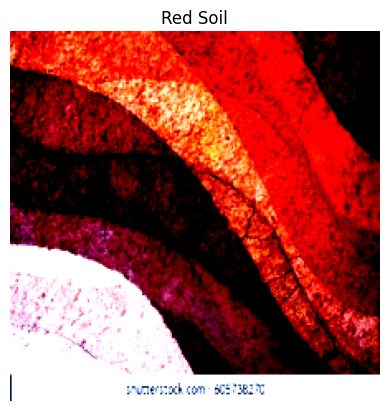

In [38]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [39]:
# Load Pretrained ViT Model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)  # Load pretrained weights  # Load pretrained weights
num_ftrs = model.heads.head.in_features  # Get input features of the classifier head
num_classes = len(class_names)  # Use number of classes in your dataset

In [40]:
# Number of last transformer layers you want to train
num_trainable_layers = 5

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier head (always train)
for param in model.heads.head.parameters():
    param.requires_grad = True

# Unfreeze last N transformer blocks
for layer in model.encoder.layers[-num_trainable_layers:]:
    for param in layer.parameters():
        param.requires_grad = True


In [41]:
import torch.optim as optim

# Modify the Classifier Head (Better Regularization)
model.heads.head = nn.Sequential(
    nn.LayerNorm(num_ftrs),  # LayerNorm for stability
    nn.Dropout(0.5),  # Increased dropout for stronger regularization
    nn.Linear(num_ftrs, 256),  # Smaller intermediate layer
    nn.GELU(),  # Activation
    nn.LayerNorm(256),  # LayerNorm for stability
    nn.Dropout(0.3),  # Increased dropout
    nn.Linear(256, num_classes)  # Final classification layer
)
# Optimizer with Stronger Regularization
optimizer = optim.AdamW([
    {"params": model.encoder.layers[-5:].parameters(), "lr": 1e-5},  
    {"params": model.heads.head.parameters(), "lr": 3e-5}  
], weight_decay=1e-3)  # Increased weight decay

# Learning Rate Scheduler (Slower Decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.5
)

In [42]:
# Print model summary
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [43]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, scheduler=None, epochs=10, save_path="best_model.pth"):
    model.to(device)
    train_accs, test_accs = [], []
    best_acc = 0.0
    best_model_wts = None
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
         # Evaluate on validation data
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total * 100
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, save_path)
            print(f"New best model saved with Test Acc: {best_acc:.2f}%")
        
        if scheduler:
            scheduler.step(100 - test_acc)

    print(f"\nBest Model Test Accuracy: {best_acc:.2f}%")
    return best_model_wts, train_accs, test_accs

def plot_accuracy(train_accs, test_accs, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_accs, label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(range(1, epochs + 1), test_accs, label="Test Accuracy", marker='o', linestyle='-')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Testing Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


In [44]:
criterion = torch.nn.CrossEntropyLoss()
best_model_wts, train_accs, test_accs = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, device, scheduler, epochs=15)

Epoch [1/15], Train Acc: 39.07%, Test Acc: 70.25%
New best model saved with Test Acc: 70.25%
Epoch [2/15], Train Acc: 54.52%, Test Acc: 77.85%
New best model saved with Test Acc: 77.85%
Epoch [3/15], Train Acc: 67.64%, Test Acc: 87.34%
New best model saved with Test Acc: 87.34%
Epoch [4/15], Train Acc: 77.55%, Test Acc: 94.30%
New best model saved with Test Acc: 94.30%
Epoch [5/15], Train Acc: 83.67%, Test Acc: 95.57%
New best model saved with Test Acc: 95.57%
Epoch [6/15], Train Acc: 87.46%, Test Acc: 94.94%
Epoch [7/15], Train Acc: 87.46%, Test Acc: 94.94%
Epoch [8/15], Train Acc: 87.76%, Test Acc: 96.20%
New best model saved with Test Acc: 96.20%
Epoch [9/15], Train Acc: 88.92%, Test Acc: 96.20%
Epoch [10/15], Train Acc: 91.25%, Test Acc: 96.20%
Epoch [11/15], Train Acc: 90.38%, Test Acc: 96.20%
Epoch [12/15], Train Acc: 90.38%, Test Acc: 96.84%
New best model saved with Test Acc: 96.84%
Epoch [13/15], Train Acc: 92.42%, Test Acc: 96.84%
Epoch [14/15], Train Acc: 93.59%, Test Acc: 9

In [47]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

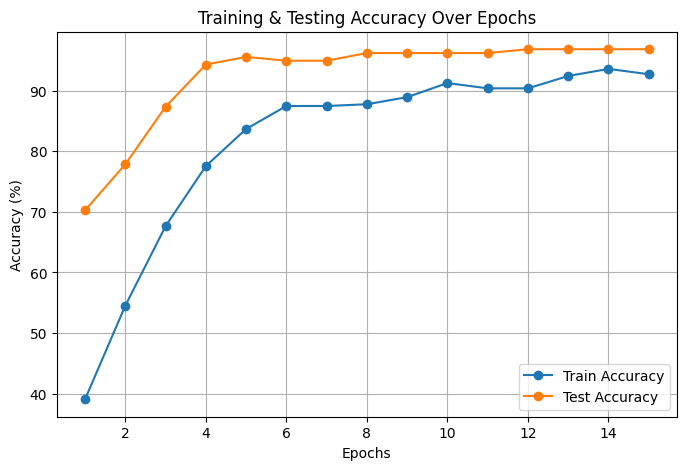

In [48]:
# Plot accuracy curves
plot_accuracy(train_accs, test_accs, epochs=15)